### setting

In [1]:
pip install pi-heaan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import piheaan as heaan
from piheaan.math import sort
from piheaan.math import approx # for piheaan math function
import math
import numpy as np
import pandas as pd
import os

In [3]:
# set parameter
params = heaan.ParameterPreset.FGb
context = heaan.make_context(params) # context has paramter information
heaan.make_bootstrappable(context) # make parameter bootstrapable

# create and save keys
key_file_path = "./keys"
sk = heaan.SecretKey(context) # create secret key
os.makedirs(key_file_path, mode=0o775, exist_ok=True)
sk.save(key_file_path+"/secretkey.bin") # save secret key

key_generator = heaan.KeyGenerator(context, sk) # create public key
key_generator.gen_common_keys()
key_generator.save(key_file_path+"/") # save public key

In [4]:
# load secret key and public key
# When a key is created, it can be used again to save a new key without creating a new one
key_file_path = "./keys"

sk = heaan.SecretKey(context,key_file_path+"/secretkey.bin") # load secret key
pk = heaan.KeyPack(context, key_file_path+"/") # load public key
pk.load_enc_key()
pk.load_mult_key()

eval = heaan.HomEvaluator(context,pk) # to load piheaan basic function
dec = heaan.Decryptor(context) # for decrypt
enc = heaan.Encryptor(context) # for encrypt

In [5]:
# log_slots is used for the number of slots per ciphertext
# It depends on the parameter used (ParameterPreset)
# The number '15' is the value for maximum number of slots,
# but you can also use a smaller number (ex. 2, 3, 5, 7 ...)
# The actual number of slots in the ciphertext is calculated as below.
log_slots = 15 
num_slots = 2**log_slots

### cosine distance

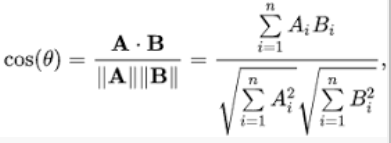

In [6]:
# a = [0.001*i for i in range(1,129)]
# b = [0.003*i for i in range(1,129)]

a = [0.01,0.02,0.03,0.04,0.05]
a = a + (num_slots-len(a))*[0]
b = [0.02,0.04,0.06,0.08,0.09]
b = b+ (num_slots-len(b))*[0]


In [7]:
print(a)
print(b)

[0.01, 0.02, 0.03, 0.04, 0.05, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [8]:
def cosin_sim(a,b,eval,enc,dec,sk,pk,log_slots,num_slots,context):

  # denominator
  msg1 = heaan.Message(log_slots)
  msg2 = heaan.Message(log_slots)
  for i in range(num_slots):
    msg1[i] = a[i]
    msg2[i] = b[i]

  # mult 
  ctxt1 = heaan.Ciphertext(context)
  ctxt2 = heaan.Ciphertext(context)
  ctxt3 = heaan.Ciphertext(context)

  enc.encrypt(msg1, pk, ctxt1)
  enc.encrypt(msg2, pk, ctxt2)
  eval.mult(ctxt1, ctxt2, ctxt3)

  # sigma
  denom_ctxt = heaan.Ciphertext(context)
  eval.left_rotate_reduce(ctxt3,1,num_slots,denom_ctxt)

  # numerator

  ## 루트씌우니까 오차값이 소수점 넷째자리부터 발생. 루트 빼고 하는 방법 탐색. 

  # square
  ctxt1_sqr = heaan.Ciphertext(context)
  eval.square(ctxt1, ctxt1_sqr)

  ctxt2_sqr = heaan.Ciphertext(context)
  eval.square(ctxt2, ctxt2_sqr)

  # sigma
  ctxt1_rot = heaan.Ciphertext(context)
  eval.left_rotate_reduce(ctxt1_sqr,1,num_slots,ctxt1_rot)

  ctxt2_rot = heaan.Ciphertext(context)
  eval.left_rotate_reduce(ctxt2_sqr,1,num_slots,ctxt2_rot)

  # sqrt

  ## input range : 2^-18 ≤ x ≤ 2
  ctxt1_sqrt = heaan.Ciphertext(context)
  approx.sqrt(eval,ctxt1_rot,ctxt1_sqrt)

  ctxt2_sqrt = heaan.Ciphertext(context)
  approx.sqrt(eval,ctxt2_rot,ctxt2_sqrt)

  # mult and inverse 

  ## inverse range : 1 ≤ x ≤ 2^22 or 2^-10 ≤ x ≤ 1
  num_ctxt = heaan.Ciphertext(context)
  eval.mult(ctxt1_sqrt, ctxt2_sqrt, num_ctxt)
  eval.mult(num_ctxt,1000,num_ctxt)

  num_inverse = heaan.Ciphertext(context)
  approx.inverse(eval,num_ctxt,num_inverse)
  eval.mult(num_inverse,1000, num_inverse)

  eval.bootstrap(num_inverse, num_inverse)

  # cosine similarity

  # mult denominator & numberator^-1
  res_ctxt = heaan.Ciphertext(context)
  eval.mult(num_inverse,denom_ctxt,res_ctxt)

  return res_ctxt


### euclidean distance

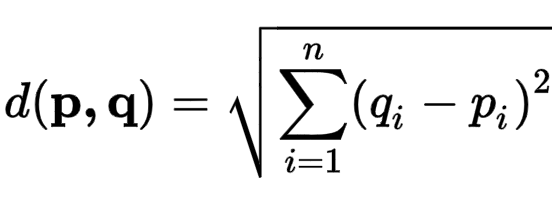

In [9]:
def euclidean_distance(a,b,eval,enc,dec,sk,pk,log_slots,num_slots,context):

  msg1 = heaan.Message(log_slots)
  msg2 = heaan.Message(log_slots)
  for i in range(num_slots):
    msg1[i] = a[i]
    msg2[i] = b[i]

  # sub
  ctxt1 = heaan.Ciphertext(context)
  ctxt2 = heaan.Ciphertext(context)
  ctxt3 = heaan.Ciphertext(context)

  enc.encrypt(msg1, pk, ctxt1)
  enc.encrypt(msg2, pk, ctxt2)
  eval.sub(ctxt1, ctxt2, ctxt3)

  # square
  ctxt_square = heaan.Ciphertext(context)
  eval.square(ctxt3, ctxt_square)

  # sigma
  ctxt_sig = heaan.Ciphertext(context)
  eval.left_rotate_reduce(ctxt_square,1,num_slots,ctxt_sig)

  # sqrt
  ## input range : 2^-18 ≤ x ≤ 2
  ctxt_sqrt = heaan.Ciphertext(context)
  approx.sqrt(eval,ctxt_sig,ctxt_sqrt)

  return ctxt_sqrt

### Compare with threshold

cos_similarity - threshold >0 일때, accept

In [17]:
def compare(type,thres,comp_ctxt,eval,enc,dec,sk,pk,log_slots,num_slots,context):
  thres_list = []
  thres_list.append(thres)

  thres_list += (num_slots-len(thres_list))*[0]

  thres_msg = heaan.Message(log_slots)
  for i in range(num_slots):
    thres_msg[i] = thres_list[i]

  sub_ctxt = heaan.Ciphertext(context)
  if type == 'cosine':
    eval.sub(comp_ctxt,thres_msg,sub_ctxt)
  elif type == 'euclidean':
    thres_ctxt = heaan.Ciphertext(context)
    enc.encrypt(thres_msg, pk, thres_ctxt)
    eval.sub(thres_ctxt,comp_ctxt,sub_ctxt)
  ## cos_similarity - threshold > 0 이면 그 값을 1로 (그냥 그 뺀값도 숨겨버려려)

  sign_ctxt = heaan.Ciphertext(context)
  approx.sign(eval, sub_ctxt, sign_ctxt)

  res = heaan.Message(log_slots)
  dec.decrypt(sign_ctxt, sk, res)

  real = res[0].real
  if -0.0001 < 1-real < 0.0001:
    res = 'This is ME!'
  else:
    res = 'Who are you?'

  return res

실행코드 

In [11]:
res_ctxt = cosin_sim(a,b,eval,enc,dec,sk,pk,log_slots,num_slots,context)

res = heaan.Message(log_slots)
dec.decrypt(res_ctxt, sk, res)
print("cosine similarity : ", res)

cosine similarity :  [ (0.998642+0.000000j), (0.998642+0.000000j), (0.998642+0.000000j), (0.998642+0.000000j), (0.998642+0.000000j), ..., (0.998642+0.000000j), (0.998642+0.000000j), (0.998642+0.000000j), (0.998642+0.000000j), (0.998642+0.000000j) ]


In [12]:
# cosine similarity > threshold -> accept

thres = 0.95
type = 'cosine'
result = compare(type,thres,res_ctxt,eval,enc,dec,sk,pk,log_slots,num_slots,context)
print(result)

This is ME!


In [13]:
res_ctxt = euclidean_distance(a,b,eval,enc,dec,sk,pk,log_slots,num_slots,context)

res = heaan.Message(log_slots)
dec.decrypt(res_ctxt, sk, res)
print("euclidean distance : ", res)

euclidean distance :  [ (0.067823+0.000000j), (0.067823+0.000000j), (0.067823+0.000000j), (0.067823+0.000000j), (0.067823+0.000000j), ..., (0.067823+0.000000j), (0.067823+0.000000j), (0.067823+0.000000j), (0.067823+0.000000j), (0.067823+0.000000j) ]


In [18]:
# euclidean distance < threshold -> accept
thres = 0.07
type = 'euclidean'
result = compare(type,thres,res_ctxt,eval,enc,dec,sk,pk,log_slots,num_slots,context)
print(result)

This is ME!


### cosine similarity with numpy

In [ ]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def cos_sim(A, B):
  return dot(A, B)/(norm(A)*norm(B))

doc1 = np.array(a)
doc2 = np.array(b)

print('문서 1과 문서2의 유사도 :',cos_sim(doc1, doc2))